# Импорт библиотек

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier # mb logreg

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import BaggingClassifier, VotingClassifier
#from sklearn.cluster import KMeans
#from sklearn.svm import SVC, OneClassSVM

from tqdm import tqdm

%matplotlib inline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [27]:
colors = ['#c93333', '#c98233', '#c99933', '#b5c933', '#5cc933', 
          '#33c942', '#33c985', '#33b3c9', '#336fc9','#5033c9',
         '#8833c9', '#a933c9', '#c933bb', '#c93361', '#c93356', '#525151', ]

sns.set(font_scale=2,
        style="whitegrid",
        rc={'figure.figsize':(20,7)})

# Вспомогательные функции

In [28]:
def evaluate_results(y_test, y_predict):
    print('Classification results:')
    print(f'f1: {f1_score(y_test, y_predict) * 100.0}')
    print(f'precision: {precision_score(y_test, y_predict) * 100.0}')
    print(f'recall: {recall_score(y_test, y_predict) * 100.0}')

def data_oversample(X_train, y_train):
    data_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
    class_0,class_1 = data_train['is_in_club'].value_counts()
    c0 = data_train[data_train['is_in_club'] == 0]
    c1 = data_train[data_train['is_in_club'] == 1]
    c1_over = c1.sample(class_0, replace=True)
    data_train_oversampled = np.concatenate([c0.to_numpy(), c1_over.to_numpy()], axis=0)
    
    X_train_oversampled = np.delete(data_train_oversampled, -1, 1)
    y_train_oversampled = data_train_oversampled[:, -1]
    return X_train_oversampled, y_train_oversampled

def only_club(X_data, y_data):
    data = pd.concat([pd.DataFrame(X_data), pd.DataFrame(y_data)], axis=1)
    data_only_club = data[data['is_in_club'] == 1]
    
    X_only_club= np.delete(data_only_club.to_numpy(), -1, 1)
    y_only_club = data_only_club.to_numpy()[:, -1]
    return X_only_club, y_only_club

In [29]:
data = pd.read_csv("/content/drive/MyDrive/df_cup.csv")
data

,client_id,is_in_club,cnt_checks_10_Мясная гастрономия,rto_std_11,rto_6,rto_12_Сыры,rto_12_Птица и изделия из птицы,rto_8,cnt_checks_9,rto_9_Мясная гастрономия,...,rto_stddev_12_Сыры,rto_6_Крупы и зерновые,rto_stddev_7_Рыба и рыбные изделия,rto_stddev_8_Овощи - Фрукты,rto_8_Рыба и рыбные изделия,rto_11_Сыры,cnt_checks_8_Сыры,cnt_checks_8,rto_stddev_9_Мясная гастрономия,rto_stddev_12_Крупы и зерновые
0,0,0,NaN,300.021342,2418.116714,853.016746,NaN,5092.170392,3.0,NaN,...,73.846425,148.316558,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
1,1,0,1.0,519.031384,19899.211736,NaN,NaN,32392.636661,7.0,NaN,...,NaN,NaN,225.219998,301.404157,525.868862,1153.293331,7.0,21.0,NaN,NaN
2,2,0,NaN,131.165948,411.347689,NaN,NaN,1416.656061,NaN,NaN,...,NaN,NaN,NaN,6.651813,NaN,NaN,NaN,5.0,NaN,NaN
3,3,0,2.0,NaN,35043.643030,NaN,NaN,8460.544337,7.0,1425.707450,...,NaN,NaN,NaN,NaN,743.245025,NaN,NaN,4.0,104.784828,NaN
4,4,0,1.0,856.579037,8992.835847,NaN,NaN,4914.387768,14.0,663.142041,...,NaN,NaN,NaN,30.906907,NaN,533.725164,2.0,6.0,143.967128,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135056,135056,0,NaN,196.068192,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,97.138634,NaN,NaN,NaN,NaN
135057,135057,0,1.0,402.034438,NaN,638.046313,241.225584,NaN,3.0,109.331686,...,65.491622,NaN,NaN,NaN,NaN,197.113099,NaN,NaN,NaN,NaN
135058,135058,0,NaN,512.741089,NaN,283.611949,NaN,NaN,2.0,NaN,...,2.670624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135059,135059,0,NaN,124.425093,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
new_data = pd.read_csv("/content/drive/MyDrive/df_cup_additional.csv").drop(columns='Unnamed: 0').rename(columns={'index': 'client_id'})
new_data

,client_id,cnt_unique_plu_6,cnt_unique_plu_7,cnt_unique_plu_8,cnt_unique_plu_9,cnt_unique_plu_10,cnt_unique_plu_11,cnt_unique_plu_12,cnt_unique_plu_10_Мясная гастрономия,cnt_unique_plu_10_Овощи - Фрукты,...,cnt_unique_plu_12_Крупы и зерновые,cnt_unique_plu_12_Сыры,cnt_unique_plu_6_Крупы и зерновые,cnt_unique_plu_6_Сыры,cnt_unique_plu_7_Крупы и зерновые,cnt_unique_plu_7_Сыры,cnt_unique_plu_8_Крупы и зерновые,cnt_unique_plu_8_Сыры,cnt_unique_plu_9_Крупы и зерновые,cnt_unique_plu_9_Сыры
0,0,18.0,8.0,40.0,8.0,15.0,15.0,38.0,NaN,NaN,...,NaN,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,60.0,60.0,76.0,32.0,70.0,20.0,NaN,1.0,22.0,...,NaN,NaN,NaN,2.0,NaN,3.0,NaN,4.0,1.0,1.0
2,2,4.0,4.0,17.0,NaN,1.0,10.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,113.0,65.0,37.0,42.0,14.0,9.0,NaN,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,64.0,21.0,33.0,60.0,40.0,90.0,62.0,1.0,6.0,...,NaN,NaN,NaN,2.0,NaN,1.0,NaN,2.0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135056,135056,NaN,NaN,NaN,5.0,8.0,16.0,11.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135057,135057,NaN,NaN,NaN,50.0,75.0,76.0,77.0,1.0,12.0,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
135058,135058,NaN,NaN,NaN,13.0,68.0,18.0,48.0,NaN,5.0,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135059,135059,NaN,NaN,NaN,3.0,27.0,13.0,27.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
data = data.merge(new_data, on='client_id')
data

,client_id,is_in_club,cnt_checks_10_Мясная гастрономия,rto_std_11,rto_6,rto_12_Сыры,rto_12_Птица и изделия из птицы,rto_8,cnt_checks_9,rto_9_Мясная гастрономия,...,cnt_unique_plu_12_Крупы и зерновые,cnt_unique_plu_12_Сыры,cnt_unique_plu_6_Крупы и зерновые,cnt_unique_plu_6_Сыры,cnt_unique_plu_7_Крупы и зерновые,cnt_unique_plu_7_Сыры,cnt_unique_plu_8_Крупы и зерновые,cnt_unique_plu_8_Сыры,cnt_unique_plu_9_Крупы и зерновые,cnt_unique_plu_9_Сыры
0,0,0,NaN,300.021342,2418.116714,853.016746,NaN,5092.170392,3.0,NaN,...,NaN,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,1.0,519.031384,19899.211736,NaN,NaN,32392.636661,7.0,NaN,...,NaN,NaN,NaN,2.0,NaN,3.0,NaN,4.0,1.0,1.0
2,2,0,NaN,131.165948,411.347689,NaN,NaN,1416.656061,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,2.0,NaN,35043.643030,NaN,NaN,8460.544337,7.0,1425.707450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,1.0,856.579037,8992.835847,NaN,NaN,4914.387768,14.0,663.142041,...,NaN,NaN,NaN,2.0,NaN,1.0,NaN,2.0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135056,135056,0,NaN,196.068192,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135057,135057,0,1.0,402.034438,NaN,638.046313,241.225584,NaN,3.0,109.331686,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
135058,135058,0,NaN,512.741089,NaN,283.611949,NaN,NaN,2.0,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135059,135059,0,NaN,124.425093,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Выделение признаков

In [32]:
# категории товаров
products = ["Крупы и зерновые", 
            "Мясная гастрономия", 
            "Овощи - Фрукты", 
            "Птица и изделия из птицы", 
            "Рыба и рыбные изделия", 
            "Сыры"]

# выделение признаков суммы товарооборота в месяц
features_rto = [f'rto_{i}' for i in range(6, 13)]

# выделение признаков суммы товарооборота в месяц по категориям товаров
features_rto_prod = [f'rto_{i}_{j}' for i in range(6, 13) for j in products]

# выделение признаков стандартного отклонения суммы товарооборота от чека к чеку
features_rto_std = [f'rto_std_{i}' for i in range(6, 13)]

# выделение признаков стандартного отклонения суммы товарооборота от чека к чеку по категории товаров
features_rto_std_prod = [f'rto_stddev_{i}_{j}' for i in range(6, 13) for j in products]

# выделение признаков количества чеков в месяц
features_cnt_checks = [f'cnt_checks_{i}' for i in range(6, 13)]

# выделение признаков количества чеков в месяц в определенной категории
features_cnt_checks_prod = [f'cnt_checks_{i}_{j}' for i in range(6, 13) for j in products]

# выделение признаков количества уникальных чеков в месяц
features_cnt_unique_plu = [f'cnt_unique_plu_{i}' for i in range(6, 13)]

# выделение признаков количества уникальных чеков в месяц в определенной категории
features_cnt_unique_plu_prod = [f'cnt_unique_plu_{i}_{j}' for i in range(6, 13) for j in products]

features_all = features_rto + features_rto_prod + features_cnt_checks + features_cnt_checks_prod  + features_rto_std + features_rto_std_prod

features_final = features_rto + features_rto_prod + features_cnt_checks + features_cnt_checks_prod + features_cnt_unique_plu + features_cnt_unique_plu_prod + features_rto_std + features_rto_std_prod

# целевой признак
feature_target = ["is_in_club"]

In [33]:
data['rto_std_sum'] = data['rto_std_6'] + data['rto_std_7'] + data['rto_std_8'] + data['rto_std_9'] + data['rto_std_10'] + data['rto_std_11'] + data['rto_std_12']

# Генерация новых признаков

In [34]:
# суммы товарооборота по месяцам по категориям товаров
for i in range(6, 13):
  data[f"rto_{i}_prod_sum"] = data[[f'rto_{i}_{j}' for j in products]].sum(axis = 1)

for i in range(6, 13):
  data[f"cnt_checks_prod_{i}_sum"] = data[[f'cnt_checks_{i}_{j}' for j in products]].sum(axis = 1)

# доля товаров из ЗОЖ категории в товарообороте за месяц
for i in range(6, 13):
  data[f"rto_{i}_prod_perc"] = data[f"rto_{i}_prod_sum"] / data[f"rto_{i}"]

# средний чек по месяцам
for i in range(6, 13):
  data[f"mean_check_{i}"] = data[f'rto_{i}'] / data[f'cnt_checks_{i}']


data['rto_sum'] = data[features_rto].sum(axis = 1) 
data['rto_prod_sum'] = data[features_rto_prod].sum(axis = 1) 

data['cnt_checks_sum'] = data[features_cnt_checks].sum(axis = 1)
data['cnt_checks_prod_sum'] = data[features_cnt_checks_prod].sum(axis = 1)

data["rto_prod_perc"] = data['rto_prod_sum'] / data['rto_sum']
data["checks_prod_perc"] = data['cnt_checks_prod_sum'] / data['cnt_checks_sum']

In [35]:
features_agg = 'rto_sum' + 'rto_prod_sum' + 'cnt_checks_sum' + 'cnt_checks_prod_sum' + 'rto_prod_perc' + 'checks_prod_perc'

In [36]:
# порог доли ЗОЖ товаров, необходимых для страйка
treshold_strike = 0.4

# количество месяцев, в которых доля ЗОЖ товаров в чеке превысила пороговое значение
data["strike"] = (data[[f"rto_{i}_prod_perc" for i in range(6, 13)]] > treshold_strike).sum(axis = 1)

# Восстановление пропущенных значений

In [37]:
data = data.fillna(0)

# Первичный анализ данных

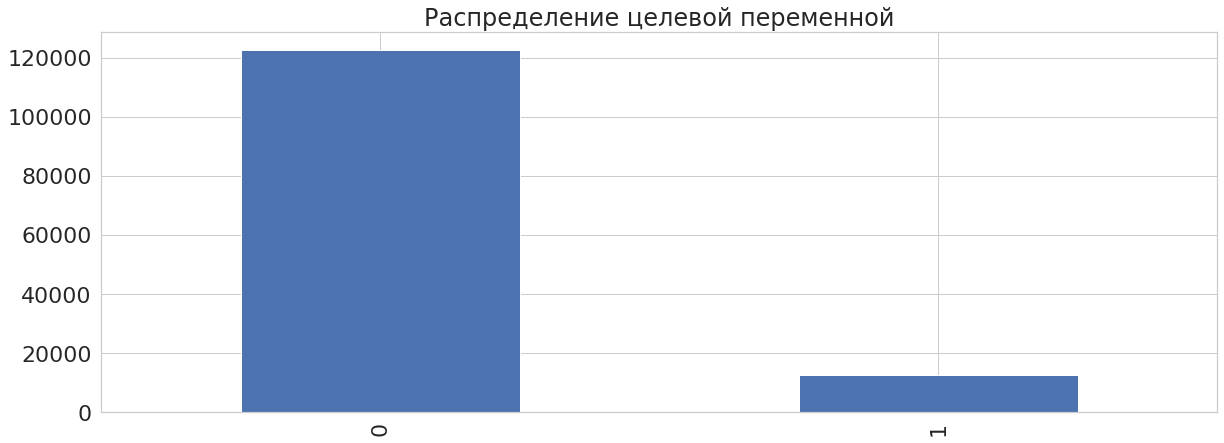

In [38]:
# распределение по таргету 
data['is_in_club'].value_counts().plot.bar()
plt.title('Распределение целевой переменной');

In [39]:
features_to_analysis = feature_target + ['rto_sum', 'rto_prod_sum', "rto_prod_perc", "checks_prod_perc"]

In [40]:
data_extr = data[features_to_analysis].copy()

In [41]:
data_extr.corr().style.background_gradient(cmap='coolwarm')

,is_in_club,rto_sum,rto_prod_sum,rto_prod_perc,checks_prod_perc
is_in_club,1.000000,0.166556,0.189555,0.102809,0.118443
rto_sum,0.166556,1.000000,0.876590,0.085134,0.336942
rto_prod_sum,0.189555,0.876590,1.000000,0.385240,0.516866
rto_prod_perc,0.102809,0.085134,0.385240,1.000000,0.639830
checks_prod_perc,0.118443,0.336942,0.516866,0.639830,1.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


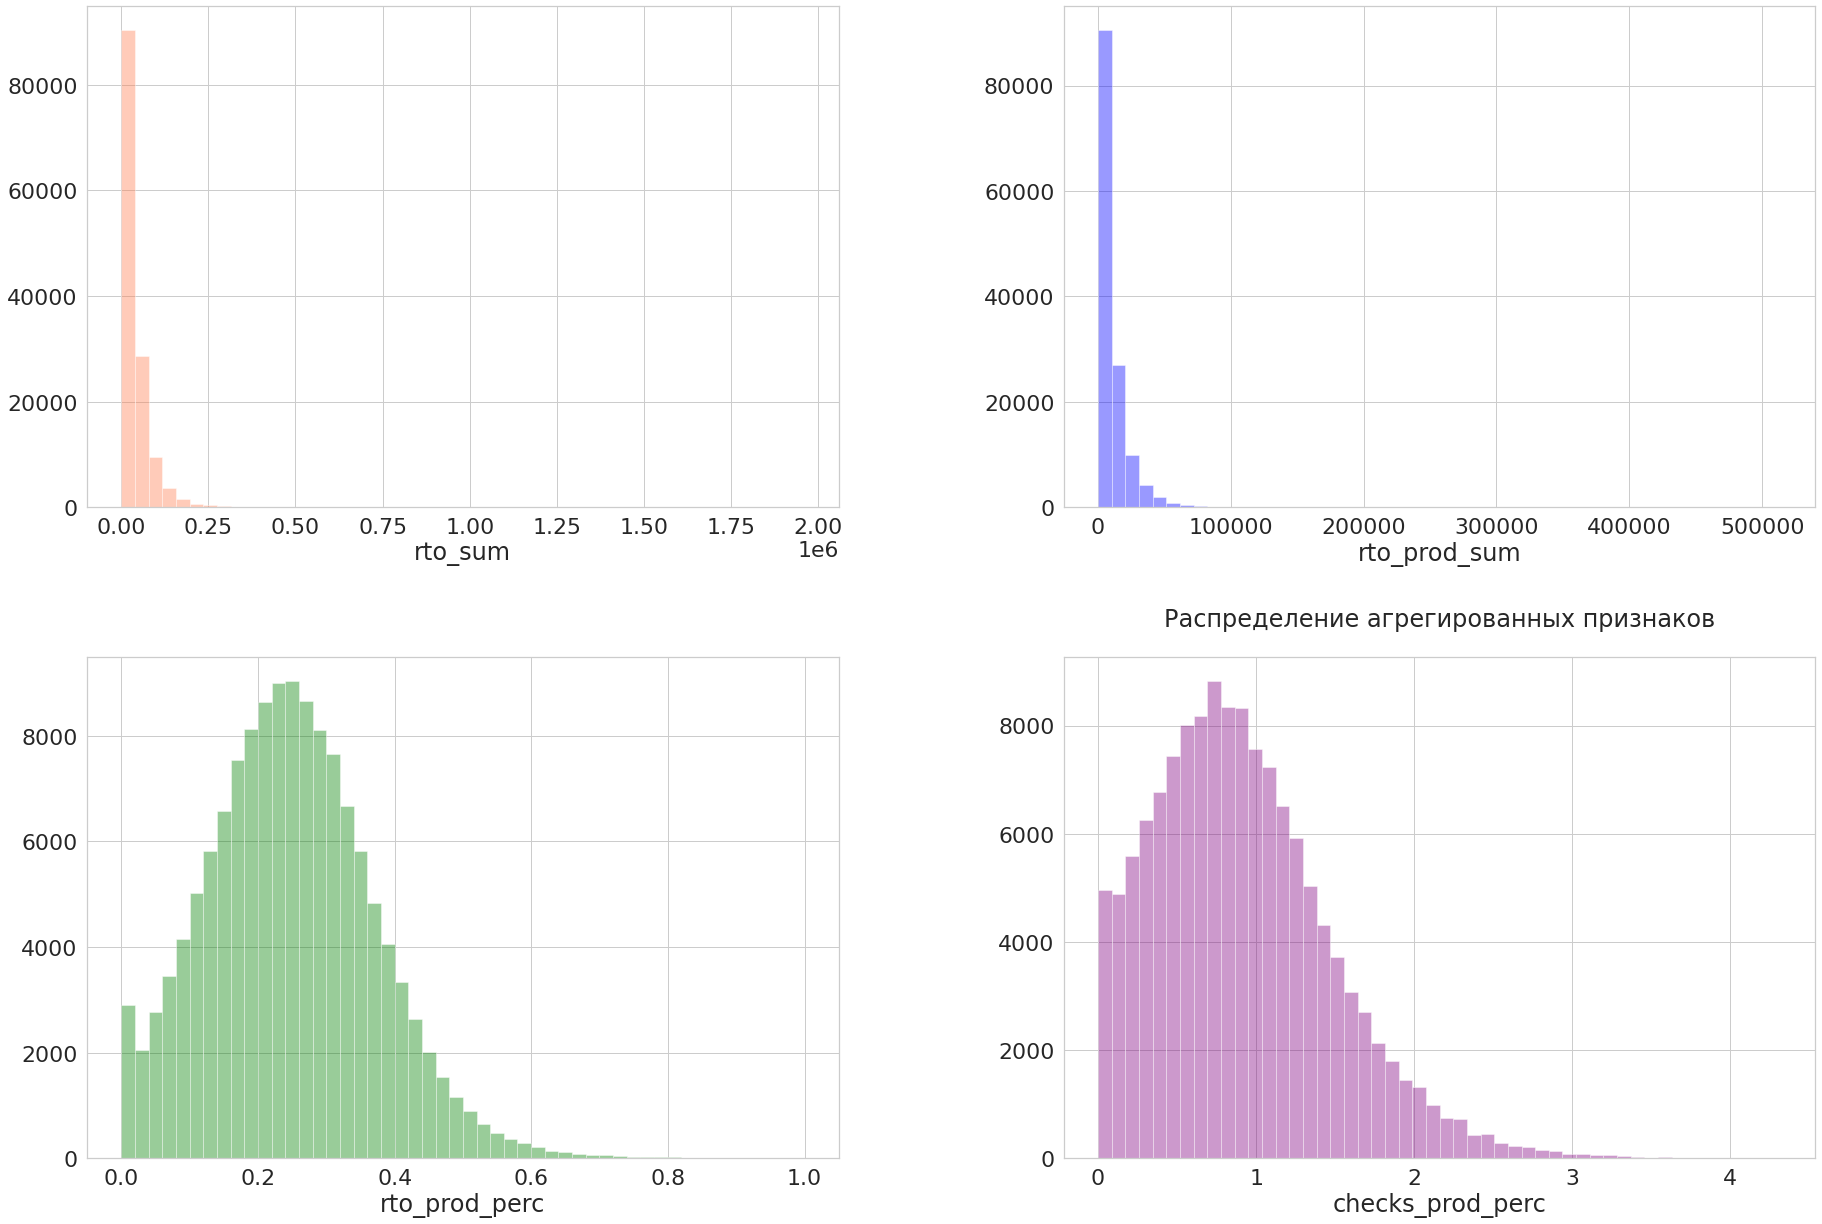

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30, 20), sharey='col', sharex=True)     

colors = ['coral', 'blue', 'green', 'purple']

plt.subplot(2, 2, 1)
sns.distplot(data['rto_sum'], kde=False, color = 'coral')
plt.subplot(2, 2, 2) 
sns.distplot(data['rto_prod_sum'], kde=False, color = 'blue')
plt.subplot(2, 2, 3) 
sns.distplot(data['rto_prod_perc'], kde=False, color = 'green')
plt.subplot(2, 2, 4) 
sns.distplot(data['checks_prod_perc'], kde=False, color = 'purple')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3,
                    hspace=0.3)

plt.title('Распределение агрегированных признаков', loc='center', y = 1.05);

# Подготовка датасета для модели

In [46]:
zeros = data[data['is_in_club'] == 0]
zeros = zeros[(zeros['cnt_checks_prod_sum'] < zeros['cnt_checks_prod_sum'].quantile(.05)) | (zeros['cnt_checks_prod_sum'] > zeros['cnt_checks_prod_sum'].quantile(.95))]
droped_list = zeros.client_id.tolist()
new_data = data.query(f"index not in {droped_list}")

In [48]:
features_agg = ['rto_sum', 'rto_prod_sum', 'cnt_checks_sum', 'cnt_checks_prod_sum', 'rto_prod_perc', 'checks_prod_perc']

In [49]:
# Итоговые фичи
features_final = features_rto + features_rto_prod + features_cnt_checks + features_cnt_checks_prod +\
                 features_cnt_unique_plu + features_cnt_unique_plu_prod + features_rto_std +\
                 features_rto_std_prod + features_agg
  

In [67]:
y_data = new_data['is_in_club']
X_data = new_data[features_final + ['client_id']]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    train_size=0.7,
                                                    random_state = 42,
                                                    shuffle = True,
                                                    stratify = new_data['is_in_club']) 
data_submit = X_test.copy()

X_train = X_train.drop(columns='client_id')
X_test = X_test.drop(columns='client_id')

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Модель

In [68]:
%%time
estimator_lgbm = LGBMClassifier() 

# гиперпараметры модели
param_lgbm = {'n_estimators': 106,
              'learning_rate': 0.044464001700569845, 
              'num_leaves': 58, 
              'lambda_l2': 1, 
              'min_data_in_leaf': 810, 
              'subsample': 0.43174221475495306, 
              'colsample_bytree': 0.6040274196431565, 
              'scale_pos_weight': 5}
 
estimator_lgbm.set_params(**param_lgbm);

estimator_lgbm.fit(X_train, y_train);

print('\nTest score:')
evaluate_results(y_test, estimator_lgbm.predict(X_test))

print('\nTrain score:')
evaluate_results(y_train, estimator_lgbm.predict(X_train))


Test score:
Classification results:
f1: 38.02221047065045
precision: 37.45767126855952
recall: 38.604026845637584

Train score:
Classification results:
f1: 47.715001391594775
precision: 46.22519413287316
recall: 49.30403773150811
CPU times: user 22.4 s, sys: 102 ms, total: 22.5 s
Wall time: 12.1 s


In [61]:
# валидация
CV_model = cross_validate(estimator_lgbm, X_test, y_test, cv=5, scoring = ['f1'], return_estimator =True)
print(CV_model['test_f1'])

[0.37844037 0.32142857 0.35115431 0.36968577 0.35775336]


In [69]:
solution = {'client_id': data_submit["client_id"].values, 'is_in_club': estimator_lgbm.predict(X_test)}
submit = pd.DataFrame(data = solution)
submit.to_csv('it_cup_solution.csv')